<a href="https://colab.research.google.com/github/kim-ji-youn/seq2seq/blob/main/tensorflow_seq2seq_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.7.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.7.0


In [ ]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3 MB 25 kB/s 
     |████████████████████████████████| 3.8 MB 46.2 MB/s 
     |████████████████████████████████| 503 kB 37.6 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=a6273e6cad634b2fd457f58413152561064d635acc874f73901482d92fc577a0
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
import data_utils
import matplotlib.pyplot as plt

In [ ]:
# read dataset
X, Y, en_word2idx, en_idx2word, en_vocab, de_word2idx, de_idx2word, de_vocab = data_utils.read_dataset('data.pkl')

In [ ]:
# inspect data
print('Sentence in English - encoded:', X[0])
print('Sentence in German - encoded:', Y[0])
print('Decoded:\n------------------------')

for i in range(len(X[1])):
    print(en_idx2word[X[1][i]])
    
print('\n')

for i in range(len(Y[1])):
    print(de_idx2word[Y[1][i]])

Sentence in English - encoded: [13, 20, 3, 21, 766, 14, 53, 76, 194, 1296, 3]
Sentence in German - encoded: [17, 25, 251, 29, 83, 19, 87, 7, 14, 110, 5371, 3091, 4]
Decoded:
------------------------
a
little
girl
climbing
into
a
wooden
playhouse



ein
kleines
mädchen
klettert
in
ein
spielhaus
aus
holz



In [ ]:
# data processing

# data padding
def data_padding(x, y, length = 15):
    for i in range(len(x)):
        x[i] = x[i] + (length - len(x[i])) * [en_word2idx['<pad>']]
        y[i] = [de_word2idx['<go>']] + y[i] + [de_word2idx['<eos>']] + (length-len(y[i])) * [de_word2idx['<pad>']]

data_padding(X, Y)

# data splitting
X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

del X
del Y

In [ ]:
input_seq_len = 15
output_seq_len = 17
en_vocab_size = len(en_vocab) + 2 # + <pad>, <ukn>
de_vocab_size = len(de_vocab) + 4 # + <pad>, <ukn>, <eos>, <go>

# placeholders
encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

targets = [decoder_inputs[i+1] for i in range(output_seq_len-1)]
# add one more target
targets.append(tf.placeholder(dtype = tf.int32, shape = [None], name = 'last_target'))
target_weights = [tf.placeholder(dtype = tf.float32, shape = [None], name = 'target_w{}'.format(i)) for i in range(output_seq_len)]

# output projection
size = 512
w_t = tf.get_variable('proj_w', [de_vocab_size, size], tf.float32)
b = tf.get_variable('proj_b', [de_vocab_size], tf.float32)
w = tf.transpose(w_t)
output_projection = (w, b)

outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                            encoder_inputs,
                                            decoder_inputs,
                                            tf.contrib.rnn.BasicLSTMCell(size),
                                            num_encoder_symbols = en_vocab_size,
                                            num_decoder_symbols = de_vocab_size,
                                            embedding_size = 100,
                                            feed_previous = False,
                                            output_projection = output_projection,
                                            dtype = tf.float32)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# define our loss function

# sampled softmax loss - returns: A batch_size 1-D tensor of per-example sampled softmax losses
def sampled_loss(labels, logits):
    return tf.nn.sampled_softmax_loss(
                        weights = w_t,
                        biases = b,
                        labels = tf.reshape(labels, [-1, 1]),
                        inputs = logits,
                        num_sampled = 512,
                        num_classes = de_vocab_size)

# Weighted cross-entropy loss for a sequence of logits
loss = tf.contrib.legacy_seq2seq.sequence_loss(outputs, targets, target_weights, softmax_loss_function = sampled_loss)

In [ ]:
# let's define some helper functions

# simple softmax function
def softmax(x):
    n = np.max(x)
    e_x = np.exp(x - n)
    return e_x / e_x.sum()

# feed data into placeholders
def feed_dict(x, y, batch_size = 64):
    feed = {}
    
    idxes = np.random.choice(len(x), size = batch_size, replace = False)
    
    for i in range(input_seq_len):
        feed[encoder_inputs[i].name] = np.array([x[j][i] for j in idxes], dtype = np.int32)
        
    for i in range(output_seq_len):
        feed[decoder_inputs[i].name] = np.array([y[j][i] for j in idxes], dtype = np.int32)
        
    feed[targets[len(targets)-1].name] = np.full(shape = [batch_size], fill_value = de_word2idx['<pad>'], dtype = np.int32)
    
    for i in range(output_seq_len-1):
        batch_weights = np.ones(batch_size, dtype = np.float32)
        target = feed[decoder_inputs[i+1].name]
        for j in range(batch_size):
            if target[j] == de_word2idx['<pad>']:
                batch_weights[j] = 0.0
        feed[target_weights[i].name] = batch_weights
        
    feed[target_weights[output_seq_len-1].name] = np.zeros(batch_size, dtype = np.float32)
    
    return feed

# decode output sequence
def decode_output(output_seq):
    words = []
    for i in range(output_seq_len):
        smax = softmax(output_seq[i])
        idx = np.argmax(smax)
        words.append(de_idx2word[idx])
    return words

In [ ]:
# ops and hyperparameters
learning_rate = 5e-3
batch_size = 64
steps = 1000

# ops for projecting outputs
outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

# training op
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# init op
init = tf.global_variables_initializer()

# forward step
def forward_step(sess, feed):
    output_sequences = sess.run(outputs_proj, feed_dict = feed)
    return output_sequences

# training step
def backward_step(sess, feed):
    sess.run(optimizer, feed_dict = feed)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# let's train the model

# we will use this list to plot losses through steps
losses = []

# save a checkpoint so we can restore the model later 
saver = tf.train.Saver()

print('------------------TRAINING------------------')

with tf.Session() as sess:
    sess.run(init)
    
    t = time.time()
    for step in range(steps):
        feed = feed_dict(X_train, Y_train)
            
        backward_step(sess, feed)
        
        if step % 5 == 4 or step == 0:
            loss_value = sess.run(loss, feed_dict = feed)
            print('step: {}, loss: {}'.format(step, loss_value))
            losses.append(loss_value)
        
        if step % 20 == 19:
            saver.save(sess, 'checkpoints/', global_step=step)
            print('Checkpoint is saved')
            
    print('Training time for {} steps: {}s'.format(steps, time.time() - t))

------------------TRAINING------------------
step: 0, loss: 9.134349822998047
step: 4, loss: 9.044428825378418
step: 9, loss: 9.128318786621094
step: 14, loss: 9.063655853271484
step: 19, loss: 9.06450080871582
Checkpoint is saved
step: 24, loss: 9.054229736328125
step: 29, loss: 9.06181526184082
step: 34, loss: 9.029149055480957
step: 39, loss: 8.998101234436035
Checkpoint is saved
step: 44, loss: 8.981119155883789
step: 49, loss: 8.966949462890625
step: 54, loss: 8.747085571289062
step: 59, loss: 8.052192687988281
Checkpoint is saved
step: 64, loss: 6.4968390464782715
step: 69, loss: 6.136436462402344
step: 74, loss: 5.880372047424316
step: 79, loss: 5.365607738494873
Checkpoint is saved
step: 84, loss: 5.208003520965576
step: 89, loss: 5.939319610595703
step: 94, loss: 5.758228778839111
step: 99, loss: 5.262599945068359
Checkpoint is saved
step: 104, loss: 5.18416690826416
step: 109, loss: 6.074321746826172
step: 114, loss: 5.262287139892578
step: 119, loss: 4.536197662353516
Instru

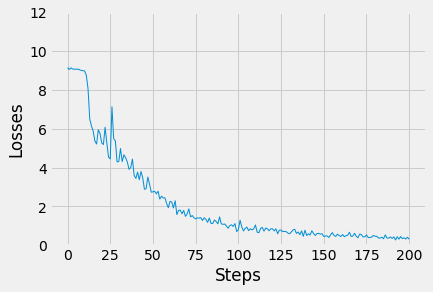

In [ ]:
# plot losses

with plt.style.context('fivethirtyeight'):
    plt.plot(losses, linewidth = 1)
    plt.xlabel('Steps')
    plt.ylabel('Losses')
    plt.ylim((0, 12))

plt.show()

In [ ]:
from torchtext.data.metrics import bleu_score
#bleu_score(candidate_corpus, references_corpus)

In [ ]:
# let's test the model
from nltk.translate.bleu_score import corpus_bleu
max_bleu = 0
max_bleu_sent = []
fo = open("./before_augumented.result.txt", "w", encoding = "utf-8")

with tf.Graph().as_default():
    
    # placeholders
    encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
    decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

    # output projection
    size = 512
    w_t = tf.get_variable('proj_w', [de_vocab_size, size], tf.float32)
    b = tf.get_variable('proj_b', [de_vocab_size], tf.float32)
    w = tf.transpose(w_t)
    output_projection = (w, b)
    
    # change the model so that output at time t can be fed as input at time t+1
    outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                                encoder_inputs,
                                                decoder_inputs,
                                                tf.contrib.rnn.BasicLSTMCell(size),
                                                num_encoder_symbols = en_vocab_size,
                                                num_decoder_symbols = de_vocab_size,
                                                embedding_size = 100,
                                                feed_previous = True, # <-----this is changed----->
                                                output_projection = output_projection,
                                                dtype = tf.float32)
    
    # ops for projecting outputs
    outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

    # let's translate these sentences
    en_sentences = []
    de_sentences = []
    de_predict = []   
    with open('test.lc.norm.tok.en.txt', 'r', encoding = 'utf-8') as f :
      for line in f.readlines():
        line = line.strip()
        en_sentences.append(line)
    
    with open('test.lc.norm.tok.de.txt', 'r', encoding= 'utf-8') as f :
      for line in f.readlines() :
        line = line.strip()
        de_sentences.append([line.split()])
    #en_sentences = ["What' s your name", 'My name is', 'What are you doing', 'I am reading a book',\
    #                'How are you', 'I am good', 'Do you speak English', 'What time is it', 'Hi', 'Goodbye', 'Yes', 'No']
    en_sentences_encoded = [[en_word2idx.get(word, 0) for word in en_sentence.split()] for en_sentence in en_sentences]
    
    # padding to fit encoder input
    for i in range(len(en_sentences_encoded)):
        en_sentences_encoded[i] += (15 - len(en_sentences_encoded[i])) * [en_word2idx['<pad>']]
    
    # restore all variables - use the last checkpoint saved
    saver = tf.train.Saver()
    path = tf.train.latest_checkpoint('checkpoints')
    
    with tf.Session() as sess:
        # restore
        saver.restore(sess, path)
        
        # feed data into placeholders
        feed = {}
        for i in range(input_seq_len):
            feed[encoder_inputs[i].name] = np.array([en_sentences_encoded[j][i] for j in range(len(en_sentences_encoded))], dtype = np.int32)
            
        feed[decoder_inputs[0].name] = np.array([de_word2idx['<go>']] * len(en_sentences_encoded), dtype = np.int32)
        
        # translate
        output_sequences = sess.run(outputs_proj, feed_dict = feed)
        
        # decode seq.
        for i in range(len(en_sentences_encoded)):
            print('{}.\n--------------------------------'.format(i+1))
            fo.write('{}.\n--------------------------------'.format(i+1) + "\n")
            ouput_seq = [output_sequences[j][i] for j in range(output_seq_len)]
            #decode output sequence
            words = decode_output(ouput_seq)
        
            print("input sentence:", en_sentences[i])
            fo.write("input sentence: " + str(en_sentences[i]) + "\n")
            print("reference: ", de_sentences[i])
            fo.write("reference: " + str(de_sentences[i]) + "\n")
            reference = de_sentences[i]
            predicted = ""
            de_sent = []
            for j in range(len(words)):
                if words[j] not in ['<eos>', '<pad>', '<go>']:
                    #print("predicted: ", end = " ")
                    #print(words[j], end = " ")
                    de_sent.append(words[j])
            
            de_predict.append(de_sent)
            print("predicted: ", ' '.join(de_sent))
            fo.write("predicted: " + ' '.join(de_sent) + "\n")
            sent_bleu = corpus_bleu([reference], [de_sent], weights = (0.5,0.5,0,0))
            print(sent_bleu)
            fo.write(str(sent_bleu) + "\n")
            if sent_bleu > 0.7 :
              max_bleu = sent_bleu
              max_bleu_sent.append((en_sentences[i], de_sentences[i], de_sent))
            print('\n--------------------------------')
            fo.write("--------------------------------\n\n")
fo.close()

INFO:tensorflow:Restoring parameters from checkpoints/-999
1.
--------------------------------
input sentence: a young man participates in a career while the subject who records it smiles
reference:  [['ein', 'junger', 'mann', 'nimmt', 'an', 'einem', 'lauf', 'teil', 'und', 'derjenige', 'der', 'dies', 'aufzeichnet', 'lächelt']]
predicted:  ein junger mann steht in einem stuhl und macht das erwachsenen der andere sprung  sie
0.223606797749979

--------------------------------
2.
--------------------------------
input sentence: the man is scratching the back of his neck while looking for a book in a book store
reference:  [['der', 'mann', 'sucht', 'in', 'einer', 'buchhandlung', 'nach', 'einem', 'buch', 'und', 'kratzt', 'sich', 'dabei', 'im', 'nacken']]
predicted:  der mann fährt die ladefläche von seinem gras für ein buch  er  
0.11952286093343935

--------------------------------
3.
--------------------------------
input sentence: a person wearing goggles and a hat is sled riding
referen

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
447.
--------------------------------
input sentence: person sitting on a stone pier beside a large body of water
reference:  [['eine', 'person', 'sitzt', 'auf', 'einem', 'steinernen', 'landesteg', 'am', 'rande', 'eines', 'großen', 'gewässers']]
predicted:  eine person sitzt auf einem steinbank neben einem großen wasserfläche  person sitzt  
0.3380617018914066

--------------------------------
448.
--------------------------------
input sentence: people running in the snow as a snowball almost hits a man with a camera
reference:  [['leute', 'rennen', 'im', 'schnee', 'als', 'ein', 'schneeball', 'fast', 'einen', 'mann', 'mit', 'fotoapparat', 'trifft']]
predicted:  ein paar im schnee  während ein kamera ein mann mit kamera   
0.21821789023599233

--------------------------------
449.
--------------------------------
input sentence: a crowd of people in the snow while a man in a green jacket throws a snowball
reference:  [['eine', 'menschenmenge', 'im', 

In [ ]:
print(max_bleu)
for s in max_bleu_sent :
  for stn in s :
    print(stn)
  print()

0.7032108464077431
a white dog with a brown face is sitting on a brick walkway
[['ein', 'weißer', 'hund', 'mit', 'einem', 'braunen', 'gesicht', 'sitzt', 'auf', 'einem', 'gepflasterten', 'gehweg']]
['ein', 'weißer', 'hund', 'mit', 'einem', 'braunen', 'gesicht', 'sitzt', 'auf', 'einem', 'ziegelmauer', '', '', '']

a man is sitting alone at a table looking at his receipts
[['ein', 'mann', 'sitzt', 'allein', 'an', 'einem', 'tisch', 'und', 'blickt', 'auf', 'seine', 'kassenzettel']]
['ein', 'mann', 'sitzt', 'allein', 'an', 'einem', 'tisch', 'und', 'blickt', 'auf', 'seine', 'gesicht', '', '', '']

the brown dog carries a soccer ball in his mouth through the snow
[['der', 'braune', 'hund', 'trägt', 'einen', 'fußball', 'im', 'maul', 'durch', 'den', 'schnee']]
['der', 'braune', 'hund', 'trägt', 'einen', 'fußball', 'im', 'maul', 'durch', 'den', 'schnee', '', '']

a surfer surfing a wave on the beach
[['ein', 'surfer', 'surft', 'auf', 'einer', 'welle', 'am', 'strand']]
['ein', 'surfer', 'surft', '

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
print(corpus_bleu(de_sentences, de_predict, weights = (0.5,0.25,0.25,0)))

0.20031556093659228


In [ ]:
print(de_sentences[-1])
print(de_predict[-1])
print(corpus_bleu(de_sentences[:10], de_predict[:10]))

[['eine', 'frau', 'und', 'ein', 'mann', 'halten', 'nachts', 'am', 'strand', 'händchen', 'und', 'blicken', 'nach', 'oben', 'in', 'den', 'sternenhimmel']]
['und', 'ein', 'mann', 'hält', 'gerade', 'am', 'strand', 'und', 'sieht', 'dabei', 'in', 'nacht', 'am', 'strand', '', 'am']
0.11855438616283227


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
reference = [[["this", "is", "the", "sample"]], [['hope', 'and', 'love']]]
candidate = [['this', 'is', 'the', 'sample'], ['hope', 'and', 'love']]
print(corpus_bleu(reference, candidate, weights = (1, 0, 0, 0)))

1.0
